In [267]:
import pandas as pd
import numpy as np

In [ ]:
raw_data = pd.read_csv('./Data/test_data.csv')
raw_label = pd.read_csv('./Data/test_label.csv')

In [ ]:
data = raw_data.drop(columns=['id'])
data

In [ ]:
label = raw_label.drop(columns=['id'])
label

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# 將數據轉換成圖像矩陣格式
img_shape = (200, 103)  # 圖像大小

zeros_array = np.zeros((data.shape[0], (img_shape[0] * img_shape[1] - data.shape[1])))
data = np.hstack((data, zeros_array))

In [ ]:
num_channels = 1  # 單通道灰度圖像
data = data.reshape((data.shape[0], img_shape[0], img_shape[1], 1))

print(data.shape)  # (樣本數, 高度, 寬度, 通道數)

In [ ]:
print(data.shape)  # (樣本數, 高度, 寬度, 通道數)
import matplotlib.pyplot as plt

# Reshape to image format
img = data[0].reshape(200, -1)

# Display image as grayscale
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# 載入模型
from tensorflow import keras

model = keras.models.load_model('./Model/CNN_Gene_2023-05-16_12-32-56.h5')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.summary()

In [ ]:
last_second_layer_output = model.layers[-2].output
last_second_layer_output

In [ ]:
# 創建新模型，輸入是原始模型的輸入，輸出是中間層的輸出
predict_model = keras.Model(inputs=model.input, outputs=last_second_layer_output)

In [ ]:
predict = predict_model.predict(data)
predict

In [ ]:
from sklearn.cluster import KMeans

# 設置聚類模型的參數，這裡設置為5群
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# 進行聚類
predict_label = kmeans.fit_predict(predict)

# 打印每個樣本所屬的分類
eval_label = pd.concat([label, pd.DataFrame(predict_label, columns=['Predict'])], axis=1)
eval_label

In [ ]:
eval_label[eval_label['Predict'] == 1].value_counts()

In [ ]:
eval_label[eval_label['Predict'] == 2].value_counts()

In [ ]:
eval_label[eval_label['Predict'] == 3].value_counts()

In [ ]:
eval_label[eval_label['Predict'] == 4].value_counts()

In [ ]:
# 創建class名稱替換字典
label_dict = {}

for i in range(5):
    label_dict[i] = eval_label[eval_label['Predict'] == i]['Class'].value_counts().idxmax()

label_dict

In [ ]:
# 將predict_label轉換為class名稱
predict_label_name = pd.DataFrame([label_dict[label] for label in predict_label], columns=['Predict_Class'])

eval_label = pd.concat([eval_label, predict_label_name], axis=1)
eval_label

In [ ]:
# 計算分類的準確度
accuracy = eval_label[eval_label['Class'] == eval_label['Predict_Class']].count() / len(eval_label)
print('Accuracy:', accuracy['Class'])

In [ ]:
from sklearn.decomposition import PCA

# 創建PCA模型，將12列特徵降維到2維
pca = PCA(n_components=2)
pca_features = pca.fit_transform(predict)

eval_label = pd.concat([eval_label, pd.DataFrame(pca_features, columns=['PCA_1', 'PCA_2'])], axis=1)
eval_label

In [ ]:
import seaborn as sns

sns.lmplot(data=eval_label, x='PCA_1', y='PCA_2', hue='Class', fit_reg=False)

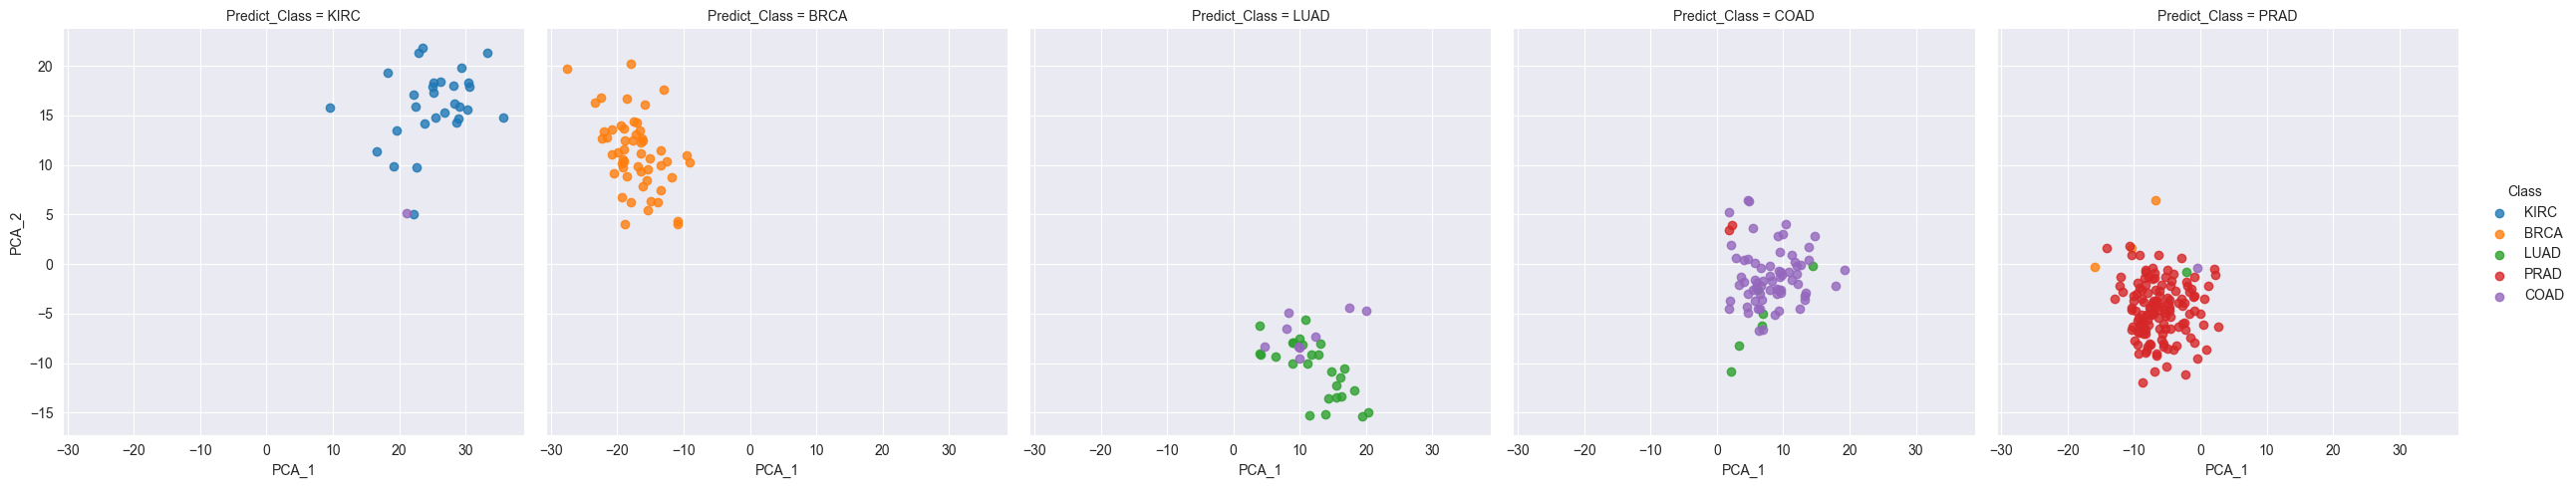

In [ ]:
import seaborn as sns

sns.lmplot(data=eval_label, x='PCA_1', y='PCA_2', hue='Class', col='Predict_Class', fit_reg=False)

In [ ]:
import os

folder_path = './Model'
file_prefix = 'Table_'
file_extension = '.csv'

# 获取文件夹中已有的CSV文件编号列表
file_numbers = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(file_extension) and file_name.startswith(file_prefix):
        file_number = int(file_name[len(file_prefix):-len(file_extension)])
        file_numbers.append(file_number)

# 计算当前最后编号加1
if file_numbers:
    next_number = max(file_numbers) + 1
else:
    next_number = 1

# 构建新的文件名
new_file_name = f'{file_prefix}{next_number}{file_extension}'

# 保存数据到新的CSV文件
to_bagging = eval_label.iloc[:, 2]
to_bagging.to_csv(os.path.join(folder_path, new_file_name), index=False)